In [ ]:
import torch
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from skimage import measure
from skimage.transform import resize
import plotly.graph_objects as go
import time
import os
device = 'cuda:0'
torch.manual_seed(0)
torch.cuda.is_available()

In [ ]:
met = np.load('Methanol.npz')

In [ ]:
for k in met:
    print(k)

In [ ]:
met['energy']

In [ ]:
    # Partial Charge
    QA = np.array([a[1] for a in Atom], dtype='float64').T
    NA = np.array([a[0] for a in Atom], dtype='float64')
    NE = NI * X3
    PC = np.zeros(len(Atom))
    vc = np.zeros(len(Atom), dtype=int)
    dis = np.zeros((N**3, len(Atom)))
    for i, a in enumerate(Atom):
        Qa = a[1][:, np.newaxis, np.newaxis, np.newaxis]
        dis[:,i] = np.sqrt(np.sum((Q-Qa)*(Q-Qa), axis=0)).reshape(N**3)
    arg = np.argmin(dis, axis=1)
    np.add.at(vc, arg, 1)
    vol = np.min(vc)
    for i, a in enumerate(Atom):
        ne_s = np.sort(NE[arg==i])
        PC[i] += np.sum(ne_s[-vol:])
    print(PC)
    print(vc)
    PC -= NA
#     print(PC)
#     print(np.sum(PC))
    return

In [ ]:
# Density Functional Theory
def calculate(config, molecule, train, result):
    t_start = time.time()
    gc.collect()
    torch.cuda.empty_cache()
    
    # Config
    Atom = []
    Qm = np.zeros((3,3))
    for i in range(len(molecule["element"])):
        Atom.append([molecule["element"][i], np.array([molecule["x"][i], molecule["y"][i], molecule["z"][i]]) * 1.889726125])
        Qm[:,0] = np.maximum(Qm[:,0], Atom[i][1])
        Qm[:,1] = np.minimum(Qm[:,1], Atom[i][1])
        Qm[:,2] += Atom[i][0] * Atom[i][1]
    Qc = Qm[:,2] / sum(molecule["element"])
    Qm -= Qc
    for a in Atom:
        a[1] -= Qc
    dx = config["dx"]
    sl = config["sl"]
    L = config["L"]
    N = config["N"]
    Z = config["Z"] + sum(molecule["element"])
    lr = config["lr"]
    fast = config["fast"]
    lumo = config["lumo"]
    ion_ene = config["ion_ene"]
    
    # Grid Space
    rX = np.full(N, dx)
    if L > np.sum(rX):
        ps = L - np.sum(rX)
        pw = round(1/2 + np.sqrt(1+4*ps/sl)/2)
        ph = (pw-1) * sl
        rX[:pw]  += np.linspace(ph, 0, pw)
        rX[-pw:] += np.linspace(0, ph, pw)
    X = np.zeros((3, N, N, N))
    X[0,:,:,:] = rX[:, np.newaxis, np.newaxis]
    X[1,:,:,:] = rX[np.newaxis, :, np.newaxis]
    X[2,:,:,:] = rX[np.newaxis, np.newaxis, :]
    X3 = (X[0]*X[1]*X[2]).reshape(N**3)
    rQ = np.cumsum(rX) - rX/2
    rQ -= np.mean(rQ)
    Q = np.zeros((3, N, N, N))
    Q[0,:,:,:] = rQ[:, np.newaxis, np.newaxis]
    Q[1,:,:,:] = rQ[np.newaxis, :, np.newaxis]
    Q[2,:,:,:] = rQ[np.newaxis, np.newaxis, :]
    L = np.sum(rX)
    
    # Initial Density
    if len(train["difference"]) == 0:
        NI = 0
        for a in Atom:
            Za = a[0]
            Qa = a[1][:, np.newaxis, np.newaxis, np.newaxis]
            Ra = np.sqrt(np.sum((Q-Qa)*(Q-Qa), axis=0))
            Ia = ion_ene[Za] / 27.211
            NI += (Za*np.sqrt(512*(Ia**3))) / (8*np.pi) * np.exp(-np.sqrt(8*Ia)*Ra)
        NI = NI.reshape(N**3)
        NI *= Z / np.sum(NI*X3)
        train["density_i"] = [NI, NI, NI]
        train["density_o"] = [NI, NI, NI]
        train["density_f"] = [0, 0, 0]
        train["N"] = N
        result["loss"] = 1e9
        print("L:", L, " N:", N, " dx:", (np.min(rX), np.max(rX)))
        print("Initial:")
        visualize(NI.reshape([N,N,N]), 1e-1)
    
    # Density Mixing
    NIp = train["density_i"]
    NOp = train["density_o"]
    NFp = train["density_f"]
    pX = np.array([1, 0, 0])
    if len(train["difference"])>3:
        pA = np.array([[np.sum(NFp[0]*NFp[0]), np.sum(NFp[0]*NFp[1]), np.sum(NFp[0]*NFp[2]), 1],
                       [np.sum(NFp[1]*NFp[0]), np.sum(NFp[1]*NFp[1]), np.sum(NFp[1]*NFp[2]), 1],
                       [np.sum(NFp[2]*NFp[0]), np.sum(NFp[2]*NFp[1]), np.sum(NFp[2]*NFp[2]), 1],
                       [                    1,                     1,                     1, 0]])
        pB = np.array([0, 0, 0, 1])
        pX = np.linalg.solve(pA, pB)
    NIm = pX[0] * NIp[0] + pX[1] * NIp[1] + pX[2] * NIp[2]
    NOm = pX[0] * NOp[0] + pX[1] * NOp[1] + pX[2] * NOp[2]
    NI = (1-lr) * NIm + lr * NOm
    if np.min(NI) < 0:
        NI = (1-lr) * NIp[0] + lr * NOp[0]
    NI *= Z / np.sum(NI*X3)
    
    # Kinetic Energy
    ra = np.roll(rX, 1)
    rb = np.roll(rX, 0)
    rc = np.roll(rX, -1)
    da = 1 / ((ra/2+rb/2) ** 2)
    db = - 1 / ((ra/2+rb/2) ** 2) - 1 / ((rb/2+rc/2) ** 2)
    dc = 1 / ((rb/2+rc/2) ** 2)
    D = sp.sparse.spdiags(np.array([np.roll(da,-1), np.roll(db,0), np.roll(dc,1)]), [-1, 0, 1], (N,N))
    Lap = sp.sparse.kronsum(sp.sparse.kronsum(D,D), D)
    T = -1/2 * Lap

    # External Energy
    V_ext0 = 0
    for a in Atom:
        Za = a[0]
        Qa = a[1][:, np.newaxis, np.newaxis, np.newaxis]
        V_ext0 += -Za / (np.sqrt(np.sum((Q-Qa)*(Q-Qa), axis=0)) + 1e-6)
    V_ext = sp.sparse.diags(V_ext0.reshape(N**3))
    
    # Hartree Energy
    V_har0 = sp.sparse.linalg.cg(Lap, -4*np.pi*NI)[0]
    V_har = sp.sparse.diags(V_har0)

    # Exchange Energy
    rho = torch.tensor(NI.reshape([N,N,N]), requires_grad=True)
    g_rho = torch.gradient(rho, spacing = [torch.tensor(rQ) for i in range(3)])
    g_rho = torch.sqrt(g_rho[0]*g_rho[0] + g_rho[1]*g_rho[1] + g_rho[2]*g_rho[2])
    ep_x = -(3/4) * np.power(3/np.pi, 1/3) * torch.pow(rho, 1/3)
    px = (g_rho/torch.pow(rho, 4/3)) * (2/9) * np.power(np.pi/3, 1/3)
    ED_x = rho * ep_x * (3*(px**2)+(np.pi**2)*torch.log(px+1)) / ((3*px+np.pi**2)*torch.log(px+1))
    ES_x = torch.sum(ED_x)
    ES_x.backward()
    V_exc0 = rho.grad.detach().numpy().reshape(N**3)
    V_exc = sp.sparse.diags(V_exc0)
    
    # Correlation Energy
    rho = torch.tensor(NI.reshape([N,N,N]), requires_grad=True)
    g_rho = torch.gradient(rho, spacing = [torch.tensor(rQ) for i in range(3)])
    g_rho = torch.sqrt(g_rho[0]*g_rho[0] + g_rho[1]*g_rho[1] + g_rho[2]*g_rho[2])
    pa = (np.log(2)-1) / (2*(np.pi**2))
    pb = 20.4562557
    rs = torch.pow(4*np.pi*rho/3, -1/3)
    ep_c = pa * torch.log(1+pb/rs+pb/(rs**2))
    pt = np.power(np.pi/3, 1/6) * (1/4) * (g_rho/torch.pow(rho, 7/6))
    ph = 0.06672632
    ED_c = rho * ep_c * torch.pow(1+pt**2, ph/ep_c)
    ES_c = torch.sum(ED_c)
    ES_c.backward()
    V_cor0 = rho.grad.detach().numpy().reshape(N**3)
    V_cor = sp.sparse.diags(V_cor0)

    # Solve
    H = (T + V_ext + V_har + V_exc + V_cor).tocoo()
    H = torch.sparse_coo_tensor(indices=torch.tensor(np.vstack([H.row, H.col])), values=torch.tensor(H.data), size=H.shape).to(device)
    if fast:
        H = H.float()
    fn = [2 for i in range(Z//2)]
    if Z % 2 == 1:
        fn.append(1)
    eigval, eigvec = torch.lobpcg(H, len(fn)+lumo, largest=False)

    # Density
    orbits_e = eigval.detach().cpu().numpy()
    orbits = eigvec.T.detach().cpu().numpy()
    orbits = orbits / np.sqrt(np.sum(orbits*orbits*X3, axis=1))[:, np.newaxis]
    NO = np.zeros(N**3, dtype=np.float32)
    for ne, orb in zip(fn, orbits[:len(fn)]):
        NO += ne * (orb**2)
    NO *= Z / np.sum(NO*X3)
    NF = NO - NI
    Dif = np.sum(np.abs(NF) * X3)
    
    # Distribution
    QA = np.array([a[1] for a in Atom], dtype='float64').T
    NA = np.array([a[0] for a in Atom], dtype='float64')
    QE = Q.reshape((3, N**3))
    NE = NI * X3

    # Total Energy
    EN = 0
    for ne, orb_e in zip(fn, orbits_e[:len(fn)]):
        EN += ne * orb_e
    EN -= np.sum((1/2) * V_har0 * NI * X3)
    EN -= np.sum(V_exc0 * NI * X3)
    EN -= np.sum(V_cor0 * NI * X3)
    EN += np.sum(ED_x.detach().numpy().reshape(N**3) * X3)
    EN += np.sum(ED_c.detach().numpy().reshape(N**3) * X3)
    for i in range(len(Atom)):
        for j in range(i+1, len(Atom)):
            EN += Atom[i][0] * Atom[j][0] / np.sqrt(np.sum((Atom[i][1]-Atom[j][1])**2))

    # Dipole Moment
    DM = np.zeros(3)
    DM += np.sum(NA[np.newaxis, :]*QA, axis=1)
    DM += np.sum(-NE[np.newaxis, :]*QE, axis=1)
    
    # Partial Charge
    PC = np.zeros(len(Atom))
    dis = np.zeros((N**3, len(Atom)))
    for i, a in enumerate(Atom):
        Qa = a[1][:, np.newaxis, np.newaxis, np.newaxis]
        dis[:,i] = np.sqrt(np.sum((Q-Qa)*(Q-Qa), axis=0)).reshape(N**3)
    arg = np.argmin(dis, axis=1)
    np.add.at(PC, arg, NE)
    PC -= NA
    
    # Train
    train["density_i"] = [NI, NIp[0], NIp[1]]
    train["density_o"] = [NO, NOp[0], NOp[1]]
    train["density_f"] = [NF, NFp[0], NFp[1]]
    train["difference"].append(Dif)
    
    # Result
    if Dif < result["loss"]:
        result["orbits"] = orbits
        result["orbits_e"] = orbits_e
        result["density"] = NI
        result["energy"] = EN
        result["dipole"] = DM
        result["charge"] = PC
        result["shape"] = [N, N, N]
        result["space"] = [L, L, L]
        result["grid"] = rX
        result["Q_atom"] = QA.T
        result["N_atom"] = NA
        result["loss"] = Dif
    
    t_end = time.time()
    print("Iteration:", len(train["difference"]), " / Time:", t_end-t_start)
    print("Difference:", Dif, " Energy:", EN)
    visualize(NO.reshape([N,N,N]), 1e-1)

In [ ]:
import numpy as np
a = np.array([-0.0343604951, 0.9775395708, 0.0076015923])
b = np.array([0.0647664923, 0.0205721989, 0.0015346341])
c = np.array([0.8717903737, 1.3007924048, 0.0006931336])
L = np.linalg.norm(a-b)
P = np.sum((a-b) * (a-c)) / np.linalg.norm(a-b) / np.linalg.norm(a-c)
T = np.arccos(P)
print("x", L*np.sin(T/2))
print("z", L*np.cos(T/2))

In [ ]:
import numpy as np
a = np.array([0, 0, 0])
b = np.array([0.757, 0, -0.5871])
c = np.array([-0.757, 0, -0.5871])
np.linalg.norm(a-b)
np.sum((a-b) * (a-c)) / np.linalg.norm(a-b) / np.linalg.norm(a-c)

In [ ]:
a = np.array([1, 4, 2, 5, 3, 6])
a<4

In [ ]:
import scipy as sp
v = np.array([1, 2, 3, 4, 5])
a = sp.sparse.diags([v], [0], format='csr')
b = (np.abs(v-3))<1.5

In [ ]:
a[b,:][:,b]

In [ ]:
a[3,3]

In [ ]:
import numpy as np
a = np.array([3, 2, 1, 3, 4, 5])
g = np.gradient(a)
g

In [ ]:
ve = np.zeros((3, 3, 3, 3))
ve[0,:,:,:] = np.arange(-1,2)[:, np.newaxis, np.newaxis]
ve[1,:,:,:] = np.arange(-1,2)[np.newaxis, :, np.newaxis]
ve[2,:,:,:] = np.arange(-1,2)[np.newaxis, np.newaxis, :]
ve

In [ ]:
def partition(NE, N):
    PAR = np.full(N, -1)
    p_par = np.moveaxis(np.meshgrid(np.arange(N[0]), np.arange(N[1]), np.arange(N[2]), indexing='ij'), 0, -1)
    p_cor = np.zeros((N[0], N[1], N[2], 3))
    p_max = np.full(N, False)
    p_max[1:N[0]-1, 1:N[1]-1, 1:N[2]-1] = True
    v_dir = np.moveaxis(np.meshgrid(np.arange(-1, 2), np.arange(-1, 2), np.arange(-1, 2), indexing='ij'), 0, -1)
    for x, y, z in v_dir.reshape((27, 3)):
        if (x, y, z) == (0, 0, 0):
            continue
        p_max[1:N[0]-1, 1:N[1]-1, 1:N[2]-1] *= NE.reshape(N)[1:N[0]-1, 1:N[1]-1, 1:N[2]-1] > NE.reshape(N)[1+x:N[0]-1+x, 1+y:N[1]-1+y, 1+z:N[2]-1+z]
    v_gra = np.moveaxis(np.gradient(NE.reshape(N)), 0, -1)
    v_gra *= (NE.reshape(N) > 0)[:,:,:,np.newaxis]
    v_gra *= 1 / (np.max(np.abs(v_gra), axis=3) + 1e-18)[:,:,:,np.newaxis]
    v_gra[p_max] = 0
    v_gri = np.round(v_gra)
    v_cor = v_gra - v_gri
    for i in range(NE.shape[0]):
        pre = np.copy(p_par)
        p_cor += v_cor[p_par[:,:,:,0], p_par[:,:,:,1], p_par[:,:,:,2], :]
        p_par += v_gri[p_par[:,:,:,0], p_par[:,:,:,1], p_par[:,:,:,2], :].astype('int64')
        p_par += np.round(p_cor).astype('int64')
        p_cor -= np.round(p_cor)
        if np.array_equal(pre, p_par):
            break
    for i, a in enumerate(Atom):
        pa = p_par[a[0], a[1], a[2], :]
        pv = (np.sum(np.abs(p_par-pa[np.newaxis,np.newaxis,np.newaxis,:]), axis=3)==0).astype('int64')
        PAR *= (1-pv)
        PAR += pv * i
    return PAR
        

In [ ]:
Result = np.load("Water.npz")

In [ ]:
PAR = partition(Result["density"], Result["shape"])

In [ ]:
visualize((PAR==0).astype(int), 0.1)
visualize((PAR==1).astype(int), 0.1)
visualize((PAR==2).astype(int), 0.1)

In [ ]:
import numpy as np

In [ ]:
Q = np.array(
[[-0.0343604951, 0.9775395708, 0.0076015923],
[0.0647664923, 0.0205721989, 0.0015346341],
[0.8717903737, 1.3007924048, 0.0006931336]]
)
Q *= 1.889726125

In [ ]:
N = np.array([-0.589706, 0.294853, 0.294853])

In [ ]:
DM = np.sum(Q * N[:, np.newaxis], axis=0)

In [ ]:
np.linalg.norm(DM) * 2.541

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as clrs
import matplotlib

N, r = 200, .1
cms = matplotlib.cm
maps = [cms.jet, cms.gray, cms.autumn]

fig = plt.figure(figsize=(6,6)) # give plots a rectangular frame
ax = fig.add_subplot(111)
pos = 2.999*np.random.rand(N,2)

for x, y in pos:
    cmi = int(y)               # an index for which map to use based on y-value
    #fc = np.random.random()   # use this for random colors selected from regional map
    fc = x/3.                  # use this for x-based colors
    color = maps[cmi](fc)      # get the right map, and get the color from the map
                      # ie, this is like, eg, color=cm.jet(.75) or color=(1.0, 0.58, 0.0, 1.0)
    circle = plt.Circle((x,y), r, color=color)   # create the circle with the color
    ax.add_artist(circle)   
ax.set_xlim(0, 3)
ax.set_ylim(0, 3)
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as clrs
import matplotlib

N, r = 200, .1
cms = matplotlib.cm
maps = [cms.jet, cms.gray, cms.autumn]

fig = plt.figure(figsize=(6,6)) # give plots a rectangular frame
ax = fig.add_subplot(111)
pos = 2.999*np.random.rand(N,2)

for x, y in pos:
    cmi = int(y)               # an index for which map to use based on y-value
    #fc = np.random.random()   # use this for random colors selected from regional map
    fc = x/3.                  # use this for x-based colors
    color = maps[cmi](fc)      # get the right map, and get the color from the map
                      # ie, this is like, eg, color=cm.jet(.75) or color=(1.0, 0.58, 0.0, 1.0)
    circle = plt.Circle((x,y), r, color=color)   # create the circle with the color
    ax.add_artist(circle)   
ax.set_xlim(0, 3)
ax.set_ylim(0, 3)
plt.axis('off')
plt.show()

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(6,6)) 
ax = fig.add_subplot(111, facecolor=(0,0,0))
ax.set_axis_off()
ax.add_artist(ax.patch)
ax.patch.set_zorder(-1)

Drawing_colored_circle = plt.Circle(( 0.6 , 0.6 ), 0.1 )

ax.set_aspect(1)
# axes.set_facecolor("black")
ax.add_artist(Drawing_colored_circle)
# plt.axis('off')
plt.show()

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def plotmolecule(molecule, charge, show_charge=True, glow=True):
    # Plot
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111)
    ax.set_facecolor('black')  # Set the face color of the axes to black
    ax.set_axis_off()

    # Atom
    a_rad = [0, 120, 140,
              182, 153, 192, 170, 155, 152, 147, 154]
    a_name = ["", "H", "He",
              "Li", "Be", "B", "C", "N", "O", "F", "Ne"]
    for i in range(len(molecule["element"])):
        e = molecule["element"][i]
        x = molecule["i"][i]
        y = molecule["j"][i]
        r = a_rad[e] * 0.0015
        c = charge[i]
        color = cm.bwr_r(np.clip(c/2+0.5, 0, 0.999))
        name = a_name[e]
        if show_charge == True:
            name += '\n' + str(round(c, 2))
        circle = plt.Circle((x, y), r, color=color, zorder=1)
        ax.add_artist(circle)
        if glow == True:
            for rg in range(1, 11):
                circle = plt.Circle((x, y), r+abs(c)*rg/50, color=color, alpha=0.08, zorder=1)
                ax.add_artist(circle)
        plt.text(x, y, name, fontsize=8, ha='center', va='center', zorder=2)

    # Bond
    for i in range(len(molecule["b_o"])):
        sx = molecule["i"][molecule["b_s"][i]-1]
        sy = molecule["j"][molecule["b_s"][i]-1]
        ex = molecule["i"][molecule["b_e"][i]-1]
        ey = molecule["j"][molecule["b_e"][i]-1]
        bo = molecule["b_o"][i]
        for j in range(bo):
            ds = -0.1 + (j+1)*0.2/(bo+1)
            plt.plot([sx+ds, ex+ds], [sy+ds, ey+ds], color='white', linewidth=2.5, zorder=0)

    L = max(max(molecule["i"])-min(molecule["i"]), max(molecule["j"])-min(molecule["j"]))
    ax.set_xlim(sum(molecule["i"])/len(molecule["i"])-L/2-1, sum(molecule["i"])/len(molecule["i"])+L/2+1)
    ax.set_ylim(sum(molecule["j"])/len(molecule["j"])-L/2-1, sum(molecule["j"])/len(molecule["j"])+L/2+1)

    plt.show()

# Example usage:
# Define your molecule and charge data
# molecule_data = ...
# charge_data = ...
# plotmolecule(molecule_data, charge_data)


In [98]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def plotmolecule(molecule, charge, show_charge=True, glow=True):
    # Plot
    fig_sz = 8
    plt.style.use('dark_background')
    fig = plt.figure(figsize=(fig_sz,fig_sz))
    ax = fig.add_subplot(111, facecolor=(0,0,0))
    ax.set_axis_off()
    ax.add_artist(ax.patch)
    ax.patch.set_zorder(-1)
    L = max(max(molecule["i"])-min(molecule["i"]), max(molecule["j"])-min(molecule["j"]))
    
    # Atom
    a_rad = [0, 120, 140,
              182, 153, 192, 170, 155, 152, 147, 154]
    a_name = ["", "H", "He",
              "Li", "Be", "B", "C", "N", "O", "F", "Ne"]
    fnt_sz = 4 * fig_sz / L
    for i in range(len(molecule["element"])):
        e = molecule["element"][i]
        x = molecule["i"][i]
        y = molecule["j"][i]
        r = a_rad[e] * 0.0015
        c = charge[i]
        color = cm.bwr_r(np.clip(c/2+0.5, 0, 0.999))
        name = a_name[e]
        if show_charge == True:
            name += '\n' + str(round(c, 2))
        circle = plt.Circle((x,y), r, color=color, zorder=1)
        ax.add_artist(circle)
        if glow == True:
            for rg in range(1,11):
                circle = plt.Circle((x,y), r+abs(c)*rg/50, color=color, alpha=0.08, zorder=1)
                ax.add_artist(circle)
        ax.annotate(name, xy=(x, y), color='black', fontsize=fnt_sz, ha='center', va='center', zorder=2)
    
    # Bond
    for i in range(len(molecule["b_o"])):
        sx = molecule["i"][molecule["b_s"][i]-1]
        sy = molecule["j"][molecule["b_s"][i]-1]
        ex = molecule["i"][molecule["b_e"][i]-1]
        ey = molecule["j"][molecule["b_e"][i]-1]
        bo = molecule["b_o"][i]
        for j in range(bo):
            ds = -0.1 + (j+1)*0.2/(bo+1)
            plt.plot([sx+ds, ex+ds], [sy+ds, ey+ds], color='white', linewidth=2.5, zorder=0)
    
    ax.set_xlim(sum(molecule["i"])/len(molecule["i"])-L/2-1, sum(molecule["i"])/len(molecule["i"])+L/2+1)
    ax.set_ylim(sum(molecule["j"])/len(molecule["j"])-L/2-1, sum(molecule["j"])/len(molecule["j"])+L/2+1)
    plt.show()
    

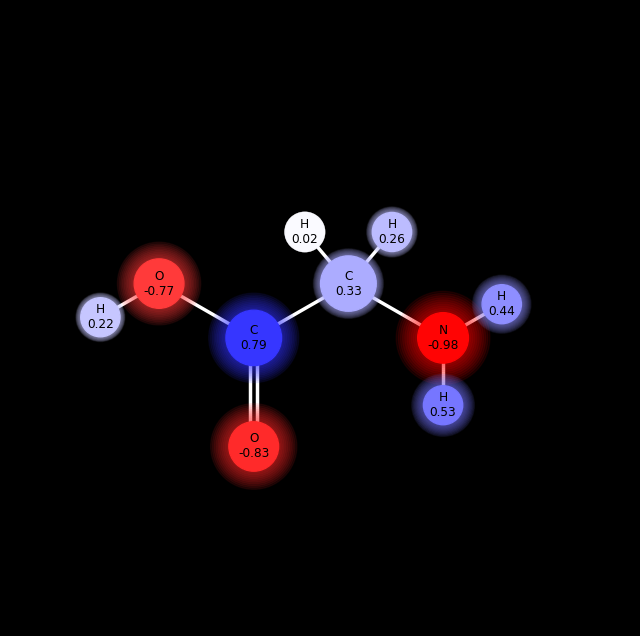

In [99]:
charge = [-0.76649618, -0.83273489, -0.9812518 ,  0.32761453,  0.786559  ,
         0.25791726,  0.01719396,  0.43851641,  0.53311484,  0.21956687]
plotmolecule(Molecule, charge)

In [ ]:
round(2.222, 2)

In [1]:
Molecule = {
    "name": "Glycine",
    "element": [
        8,
        8,
        7,
        6,
        6,
        1,
        1,
        1,
        1,
        1
    ],
    "x": [
        -1.6487,
        -0.4837,
        1.9006,
        0.7341,
        -0.5023,
        0.7326,
        0.7464,
        1.8743,
        1.8887,
        -2.4447
    ],
    "y": [
        0.6571,
        -1.2934,
        -0.0812,
        0.7867,
        -0.0691,
        1.4215,
        1.4088,
        -0.6844,
        -0.6969,
        0.0839
    ],
    "z": [
        -0.0104,
        -0.0005,
        -0.009,
        0.0079,
        0.012,
        -0.8824,
        0.9069,
        -0.8301,
        0.8031,
        -0.026
    ],
    "b_s": [
        1,
        1,
        2,
        3,
        3,
        3,
        4,
        4,
        4
    ],
    "b_e": [
        5,
        10,
        5,
        4,
        8,
        9,
        5,
        6,
        7
    ],
    "b_o": [
        1,
        1,
        2,
        1,
        1,
        1,
        1,
        1,
        1
    ],
    "i": [
        2.5369,
        3.403,
        5.135,
        4.269,
        3.403,
        4.6675,
        3.8705,
        5.672,
        5.135,
        2
    ],
    "j": [
        0.75,
        -0.75,
        0.25,
        0.75,
        0.25,
        1.225,
        1.225,
        0.56,
        -0.37,
        0.44
    ]
}

In [101]:
np.linalg.norm([5, 12])

13.0

In [ ]:
def partition(NE, N):
    Atom = Result["Q_atom"]
    
    PAR = np.full(N, -1)
    p_par = np.moveaxis(np.meshgrid(np.arange(N[0]), np.arange(N[1]), np.arange(N[2]), indexing='ij'), 0, -1)
    p_cor = np.zeros((N[0], N[1], N[2], 3))
    p_max = np.full(N, False)
    p_max[1:N[0]-1, 1:N[1]-1, 1:N[2]-1] = True
    v_dir = np.moveaxis(np.meshgrid(np.arange(-1, 2), np.arange(-1, 2), np.arange(-1, 2), indexing='ij'), 0, -1)
    for x, y, z in v_dir.reshape((27, 3)):
        if (x, y, z) == (0, 0, 0):
            continue
        p_max[1:N[0]-1, 1:N[1]-1, 1:N[2]-1] *= NE.reshape(N)[1:N[0]-1, 1:N[1]-1, 1:N[2]-1] > NE.reshape(N)[1+x:N[0]-1+x, 1+y:N[1]-1+y, 1+z:N[2]-1+z]
    v_gra = np.moveaxis(np.gradient(NE.reshape(N)), 0, -1)
    v_gra *= (NE.reshape(N) > 0)[:,:,:,np.newaxis]
    v_gra *= 1 / (np.max(np.abs(v_gra), axis=3) + 1e-18)[:,:,:,np.newaxis]
    v_gra[p_max] = 0
    v_gri = np.round(v_gra)
    v_cor = v_gra - v_gri
    
    print(np.array(np.where(p_max==True)).T)
    Atom = np.array(np.where(p_max==True)).T
    
    for i in range(N[0]):
        print(i)
        pre = np.copy(p_par)
        p_cor += v_cor[p_par[:,:,:,0], p_par[:,:,:,1], p_par[:,:,:,2], :]
        p_par += v_gri[p_par[:,:,:,0], p_par[:,:,:,1], p_par[:,:,:,2], :].astype('int64')
        p_par += np.round(p_cor).astype('int64')
        p_cor -= np.round(p_cor)
        if np.array_equal(pre, p_par):
            break
    p_par = p_par[p_par[:,:,:,0], p_par[:,:,:,1], p_par[:,:,:,2], :]
    for i, a in enumerate(Atom):
        pa = p_par[a[0], a[1], a[2], :]
        pv = (np.sum(np.abs(p_par-pa[np.newaxis,np.newaxis,np.newaxis,:]), axis=3)==0).astype('int64')
        PAR *= (1-pv)
        PAR += pv * i
    return p_par, PAR

In [ ]:
NE = Result["density"]
N = Result["shape"]

In [ ]:
p_par, PAR = partition(NE, N)

In [ ]:
print(NE.reshape(N)[1,63,77])
print(np.where((PAR<0)*(NE.reshape(N)>0)))
print(p_par[1,63,77,:])
print(p_par[75,75,74,:])
pre = p_par.copy()
post = p_par[p_par[:,:,:,0], p_par[:,:,:,1], p_par[:,:,:,2], :]
print(np.where(pre!=post))

In [ ]:
visualize(((PAR.reshape(N[0]*N[1]*N[2])<0)*(NE>0)).reshape(N).astype(int), 0.1)